In [20]:
import string 
import re 
from os import listdir 
from collections import Counter 
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer 
from keras.utils.vis_utils import plot_model 
from keras.models import Sequential 
from keras.layers import Dense
from pandas import DataFrame 
from matplotlib import pyplot



In [2]:
# load doc into memory 
def load_doc(filename): 
    # open the file as read only 
    file = open(filename,'r') 
    # read all text 
    text = file.read() 
    # close the file 
    file.close() 
    return text


In [3]:
# turn a doc into clean tokens 
def clean_doc(doc): 
    # split into tokens by white space 
    tokens = doc.split() 
    # prepare regex for char filtering 
    re_punc = re.compile('[%s]' % re.escape(string.punctuation)) 
    # remove punctuation from each word 
    tokens = [re_punc.sub('', w) for w in tokens] 
    # remove remaining tokens that are not alphabetic 
    tokens = [word for word in tokens if word.isalpha()] 
    # filter out stop words
    stop_words = set(stopwords.words('english')) 
    tokens = [w for w in tokens if not w in stop_words] 
    # filter out short tokens 
    tokens = [word for word in tokens if len(word) > 1] 
    return tokens


In [4]:
# load doc, clean and return line of tokens 
def doc_to_line(filename, vocab): 
    # load the doc 
    doc = load_doc(filename) 
    # clean doc 
    tokens = clean_doc(doc) 
    # filter by vocab 
    tokens = [w for w in tokens if w in vocab] 
    return ' '.join(tokens)


In [5]:
def save_list(lines, filename): 
    # convert lines to a single blob of text 
    data = '\n'.join(lines) 
    # open file 
    file = open(filename, 'w') 
    # write text 
    file.write(data) 
    # close file 
    file.close()


In [6]:
# load doc and add to vocab 
def add_doc_to_vocab(filename, vocab): 
    # load doc 
    doc = load_doc(filename) 
    # clean doc 
    tokens = clean_doc(doc) 
    # update counts 
    vocab.update(tokens)


In [7]:
# load all docs in a directory 
def process_docs(directory, vocab,is_train): 
    lines = list()
    # walk through all files in the folder 
    for filename in listdir(directory): 
        # skip any reviews in the test set 
        if is_train and filename.startswith('cv9'): 
            continue 
        if not is_train and not filename.startswith('cv9'): 
            continue     
        # create the full path of the file to open 
        path = directory + '/' + filename 
        # add doc to vocab 
        #add_doc_to_vocab(path, vocab)
        # load and clean the doc 
        line = doc_to_line(path, vocab) 
        # add to list 
        lines.append(line) 
    return lines



In [8]:
# load and clean a dataset 
def load_clean_dataset(vocab,is_train): 
    # load documents 
    neg = process_docs('txt_sentoken/neg', vocab,is_train) 
    pos = process_docs('txt_sentoken/pos', vocab,is_train) 
    docs = neg + pos 
    # prepare labels 
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))] 
    return docs, labels

In [9]:
# fit a tokenizer 
def create_tokenizer(lines): 
    tokenizer = Tokenizer() 
    tokenizer.fit_on_texts(lines) 
    return tokenizer


In [10]:
# define the model 
def define_model(n_words): 
    # define network 
    model = Sequential() 
    model.add(Dense(50, input_shape=(n_words,), activation='relu')) 
    model.add(Dense(1, activation='sigmoid')) 
    # compile network 
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
    # summarize defined 
    model.summary() 
    plot_model(model, to_file='model.png', show_shapes=True) 
    return model


In [11]:
# evaluate a neural network model 
def evaluate_mode(Xtrain, ytrain, Xtest, ytest): 
    scores = list() 
    n_repeats = 10 
    n_words = Xtest.shape[1] 
    for i in range(n_repeats): 
        # define network 
        model = define_model(n_words) 
        # fit network 
        model.fit(Xtrain, ytrain, epochs=10, verbose=0) 
        # evaluate
        _, acc = model.evaluate(Xtest, ytest, verbose=0) 
        scores.append(acc) 
        print('%d accuracy: %s' % ((i+1), acc)) 
        return scores


In [12]:
# prepare bag of words encoding of docs 
def prepare_data(train_docs, test_docs, mode): 
    # create the tokenizer 
    tokenizer = Tokenizer() 
    # fit the tokenizer on the documents 
    tokenizer.fit_on_texts(train_docs) 
    # encode training data set 
    Xtrain = tokenizer.texts_to_matrix(train_docs, mode=mode) 
    # encode training data set 
    Xtest = tokenizer.texts_to_matrix(test_docs, mode=mode) 
    return Xtrain, Xtest


In [22]:
# classify a review as negative or positive 
def predict_sentiment(review, vocab, tokenizer, model): 
    # clean 
    tokens = clean_doc(review) 
    # filter by vocab 
    tokens = [w for w in tokens if w in vocab] 
    # convert to line 
    line = ' '.join(tokens) 
    # encode 
    encoded = tokenizer.texts_to_matrix([line], mode='binary') 
    # predict sentiment 
    yhat = model.predict(encoded, verbose=0) 
    # retrieve predicted percentage and label 
    percent_pos = yhat[0,0] 
    if round(percent_pos) == 0: 
        return (1-percent_pos), 'NEGATIVE' 
    return percent_pos, 'POSITIVE'


In [13]:
"""
# define vocab 
vocab = Counter() 
# add all docs to vocab 
process_docs('txt_sentoken/pos', vocab) 
process_docs('txt_sentoken/neg', vocab) 
# print the size of the vocab 
print(len(vocab)) 
# print the top words in the vocab
print(vocab.most_common(50))
# keep tokens with a min occurrence 
min_occurane = 2 
tokens = [k for k,c in vocab.items() if c >= min_occurane] 
print(len(tokens)) 
# save tokens to a vocabulary file 
save_list(tokens, 'vocab.txt')
"""

"\n# define vocab \nvocab = Counter() \n# add all docs to vocab \nprocess_docs('txt_sentoken/pos', vocab) \nprocess_docs('txt_sentoken/neg', vocab) \n# print the size of the vocab \nprint(len(vocab)) \n# print the top words in the vocab\nprint(vocab.most_common(50))\n# keep tokens with a min occurrence \nmin_occurane = 2 \ntokens = [k for k,c in vocab.items() if c >= min_occurane] \nprint(len(tokens)) \n# save tokens to a vocabulary file \nsave_list(tokens, 'vocab.txt')\n"

In [14]:
"""
# load the vocabulary 
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = vocab.split() 
vocab = set(vocab) 
# load all training reviews 
docs,labels = load_clean_dataset(vocab) 
# summarize what we have 
print(len(docs), len(labels))
"""

"\n# load the vocabulary \nvocab_filename = 'vocab.txt' \nvocab = load_doc(vocab_filename) \nvocab = vocab.split() \nvocab = set(vocab) \n# load all training reviews \ndocs,labels = load_clean_dataset(vocab) \n# summarize what we have \nprint(len(docs), len(labels))\n"

In [15]:
#labels

In [16]:
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = vocab.split() 
vocab = set(vocab) 
# load all reviews 
train_docs, ytrain = load_clean_dataset(vocab, True) 
test_docs, ytest = load_clean_dataset(vocab, False) 
# create the tokenizer 
tokenizer = create_tokenizer(train_docs) 
# encode data 
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq') 
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq') 
print(Xtrain.shape, Xtest.shape)
# define the model 
n_words = Xtest.shape[1] 
model = define_model(n_words) 
# fit network 
model.fit(Xtrain, ytrain, epochs=5, verbose=2) 
# evaluate 
loss, acc = model.evaluate(Xtest, ytest, verbose=0) 
print('Test Accuracy: %f' % (acc*100))


(1800, 25768) (200, 25768)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________

Epoch 1/5
 - 2s - loss: 0.6918 - acc: 0.5094
Epoch 2/5
 - 1s - loss: 0.6831 - acc: 0.6150
Epoch 3/5
 - 1s - loss: 0.6664 - acc: 0.8206
Epoch 4/5
 - 1s - loss: 0.6402 - acc: 0.8650
Epoch 5/5
 - 2s - loss: 0.6052 - acc: 0.9244
Test Accuracy: 85.000000


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.925
       binary
count   1.000
mean    0.925
std       NaN
min     0.925
25%     0.925
50%     0.925
75%     0.925
max     0.925


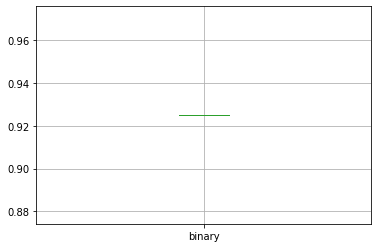

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.905
       binary  count
count   1.000  1.000
mean    0.925  0.905
std       NaN    NaN
min     0.925  0.905
25%     0.925  0.905
50%     0.925  0.905
75%     0.925  0.905
max     0.925  0.905


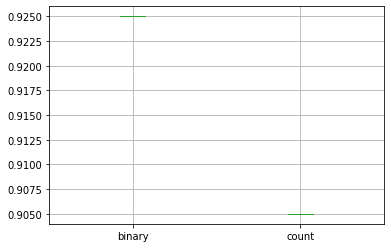

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                1288450   
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.885
       binary  count  tfidf
count   1.000  1.000  1.000
mean    0.925  0.905  0.885
std       NaN    NaN    NaN
min     0.925  0.905  0.885
25%     0.925  0.905  0.885
50%     0.925  0.905  0.885
75%     0.925  0.905  0.885
max     0.925  0.905  0.885


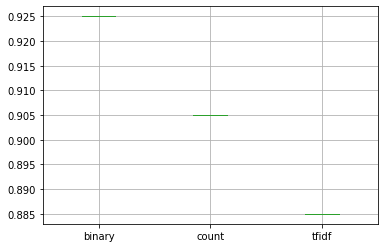

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
1 accuracy: 0.88
       binary  count  tfidf  freq
count   1.000  1.000  1.000  1.00
mean    0.925  0.905  0.885  0.88
std       NaN    NaN    NaN   NaN
min     0.925  0.905  0.885  0.88
25%     0.925  0.905  0.885  0.88
50%     0.925  0.905  0.885  0.88
75%     0.925  0.905  0.885  0.88
max     0.925  0.905  0.885  0.88


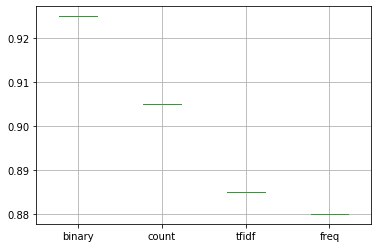

In [21]:
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = vocab.split() 
vocab = set(vocab) 
# load all reviews 
train_docs, ytrain = load_clean_dataset(vocab, True) 
test_docs, ytest = load_clean_dataset(vocab, False) 
# create the tokenizer 
tokenizer = create_tokenizer(train_docs) 
# encode data 
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq') 
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq') 
#print(Xtrain.shape, Xtest.shape)
# run experiment 
modes = ['binary', 'count', 'tfidf', 'freq'] 
results = DataFrame() 
for mode in modes: 
    # prepare data for mode 
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode) 
    # evaluate model on data for mode 
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest) 
    # summarize results 
    print(results.describe())
    # plot results 
    results.boxplot() 
    pyplot.show()



In [25]:
vocab_filename = 'vocab.txt' 
vocab = load_doc(vocab_filename) 
vocab = vocab.split() 
vocab = set(vocab) 
# load all reviews 
train_docs, ytrain = load_clean_dataset(vocab, True) 
test_docs, ytest = load_clean_dataset(vocab, False) 
# create the tokenizer 
tokenizer = create_tokenizer(train_docs) 
# encode data 
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq') 
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq') 
# define network 
n_words = Xtrain.shape[1] 
model = define_model(n_words) 
# fit network 
model.fit(Xtrain, ytrain, epochs=10, verbose=2) 
# test positive text 
text = 'Best movie ever! It was great, I recommend it.' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 50)                1288450   
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 1,288,501
Trainable params: 1,288,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
 - 2s - loss: 0.6924 - acc: 0.5189
Epoch 2/10
 - 1s - loss: 0.6855 - acc: 0.8472
Epoch 3/10
 - 1s - loss: 0.6668 - acc: 0.7633
Epoch 4/10
 - 1s - loss: 0.6354 - acc: 0.9072
Epoch 5/10
 - 1s - loss: 0.5949 - acc: 0.9317
Epoch 6/10
 - 1s - loss: 0.5488 - acc: 0.9439
Epoch 7/10
 - 1s - loss: 0.5006 - acc: 0.9461
Epoch 8/10
 - 1s - loss: 0.4527 - acc: 0.9500
Epoch 9/10
 - 1s - loss: 0.4083 - acc: 0.9583
Epoch 10/10
 - 1s - loss: 0.3660 - acc: 0.9633


In [27]:
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100)) 
# test negative text 
text = 'This is a bad movie.' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))


Review: [Best movie ever! It was great, I recommend it.]
Sentiment: POSITIVE (99.952%)
Review: [This is a bad movie.]
Sentiment: NEGATIVE (99.999%)


In [30]:
text = 'Boring I will not suggest' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [Boring I will not suggest]
Sentiment: NEGATIVE (59.429%)


In [35]:
text = 'It was nice ! i enjoyed it' 
percent, sentiment = predict_sentiment(text, vocab, tokenizer, model) 
print('Review: [%s]\nSentiment: %s (%.3f%%)' % (text, sentiment, percent*100))

Review: [It was nice ! i enjoyed it]
Sentiment: POSITIVE (99.871%)
